In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib # For saving the model
import numpy as np

# Load the processed data from Phase 1
try:
    cwe_profiles = pd.read_csv('../Data/cwe_profiles.csv', index_col='cwe_id')
    print("Successfully loaded 'cwe_profiles.csv'.")
    print(f"Dataset shape: {cwe_profiles.shape}")
except FileNotFoundError:
    print("Error: 'cwe_profiles.csv' not found. Please ensure you have completed Phase 1.")

display(cwe_profiles.head())

Successfully loaded 'cwe_profiles.csv'.
Dataset shape: (322, 13)


,base_score_mean,base_score_max,base_score_std,confidentiality_impact_numeric_mean,integrity_impact_numeric_mean,availability_impact_numeric_mean,attack_vector_<lambda>,privileges_required_<lambda>,user_interaction_<lambda>,cve_count,av_weight,pr_weight,actual_risk_score
cwe_id,,,,,,,,,,,,,
CWE-1021,6.110256,9.8,1.387684,1.338462,1.610256,0.928205,NETWORK,NONE,REQUIRED,195,1.5,1.2,10.998462
CWE-1076,6.500000,6.5,0.000000,0.000000,0.000000,3.000000,ADJACENT_NETWORK,NONE,NONE,1,1.2,1.2,9.360000
CWE-113,5.300000,5.3,0.000000,0.000000,1.000000,0.000000,NETWORK,NONE,NONE,1,1.5,1.2,9.540000
CWE-114,9.250000,10.0,0.818535,3.000000,3.000000,3.000000,NETWORK,NONE,NONE,4,1.5,1.2,16.650000
CWE-116,6.893919,9.8,1.789737,1.571429,1.591837,1.074830,NETWORK,NONE,NONE,148,1.5,1.2,12.409054


In [3]:
# The target variable we want to predict
y = cwe_profiles['actual_risk_score']

# The features are all columns except our target and the intermediate weight/lambda columns
features_to_drop = [
    'actual_risk_score',
    'av_weight',
    'pr_weight',
    'attack_vector_<lambda>',
    'privileges_required_<lambda>',
    'user_interaction_<lambda>'
]
X = cwe_profiles.drop(columns=features_to_drop)

# One-hot encode the categorical features
# This turns columns like 'attack_vector' into multiple columns like 'attack_vector_NETWORK', 'attack_vector_LOCAL', etc.
X = pd.get_dummies(X)

print("Features (X) and Target (y) have been defined.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split the data into training (80%) and testing (20%) sets
# random_state ensures we get the same split every time we run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split into {len(X_train)} training samples and {len(X_test)} testing samples.")

Features (X) and Target (y) have been defined.
Shape of X: (322, 7)
Shape of y: (322,)

Data split into 257 training samples and 65 testing samples.


In [4]:
# Initialize the XGBoost Regressor model
# These are some common starting parameters
xgbr = xgb.XGBRegressor(
    objective='reg:squarederror', # The goal is to minimize squared error
    n_estimators=1000,            # Number of decision trees to build
    learning_rate=0.05,           # How quickly the model learns
    max_depth=5,                  # Maximum depth of a tree
    random_state=42
)

print("Training the XGBoost model...")
# Train the model on our training data
xgbr.fit(X_train, y_train)
print("Model training complete.")

# Save the trained model in the models folder
from pathlib import Path
MODEL_PATH = Path('../models/vulnerability_ranker.joblib')
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(xgbr, MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH.resolve()}")


# Save the column names that were used for training
TRAINING_COLUMNS_PATH = Path('../models/training_columns.joblib')
joblib.dump(X_train.columns.tolist(), TRAINING_COLUMNS_PATH)
print(f"Training columns saved to: {TRAINING_COLUMNS_PATH.resolve()}")

Training the XGBoost model...
Model training complete.

Model saved to: D:\VulnScanAI\models\vulnerability_ranker.joblib
Training columns saved to: D:\VulnScanAI\models\training_columns.joblib



Model Performance on Test Set:
Root Mean Squared Error (RMSE): 1.6364

Sample Predictions vs. Actual Scores:


,Actual_Score,Predicted_Score
cwe_id,,
CWE-453,12.150000,15.318524
CWE-345,12.980102,11.692928
CWE-552,12.021702,12.603403
CWE-121,14.960769,12.690340
CWE-290,12.731126,11.707718
CWE-312,9.325984,9.830358
CWE-791,4.800000,7.521401
CWE-410,13.500000,13.495248
CWE-669,13.332414,13.330734


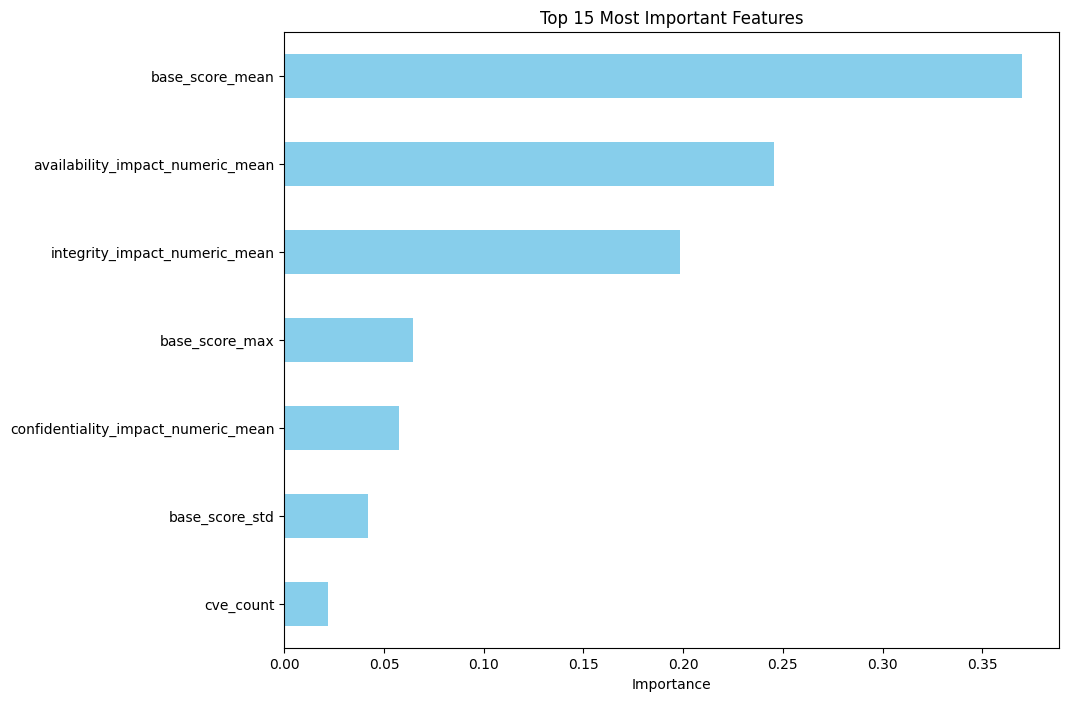

In [5]:
# Make predictions on the unseen test data
y_pred = xgbr.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE)
# We get the MSE first, then take the square root for RMSE.
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Calculate RMSE manually

print(f"\nModel Performance on Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Let's look at a few predictions vs actual values
predictions_df = pd.DataFrame({'Actual_Score': y_test, 'Predicted_Score': y_pred})
print("\nSample Predictions vs. Actual Scores:")
display(predictions_df.head(10))

# --- Feature Importance ---
# Let's see which features the model found most important
feature_importances = pd.Series(xgbr.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
feature_importances.head(15).sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance')
plt.show()

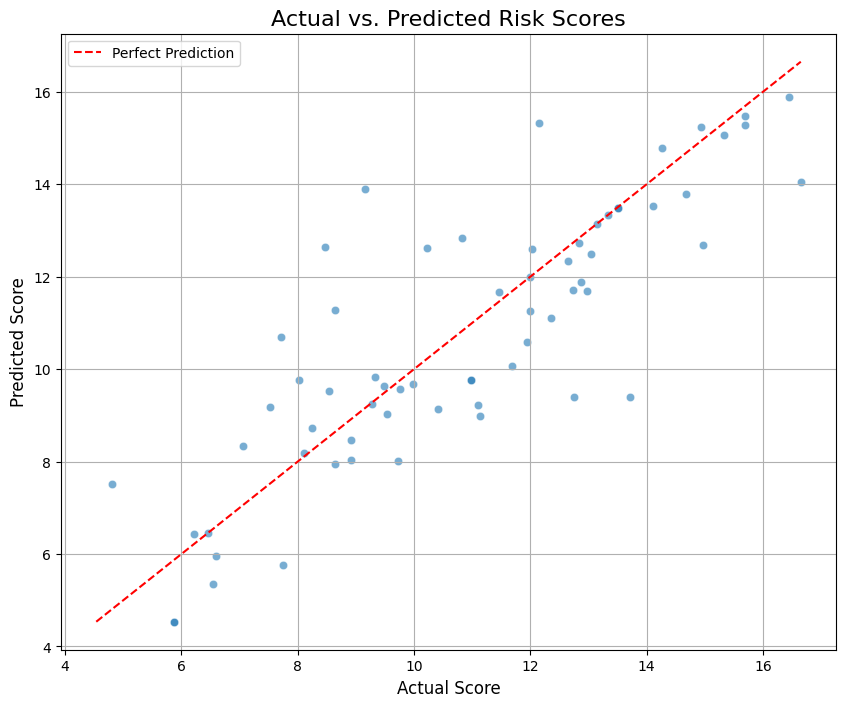

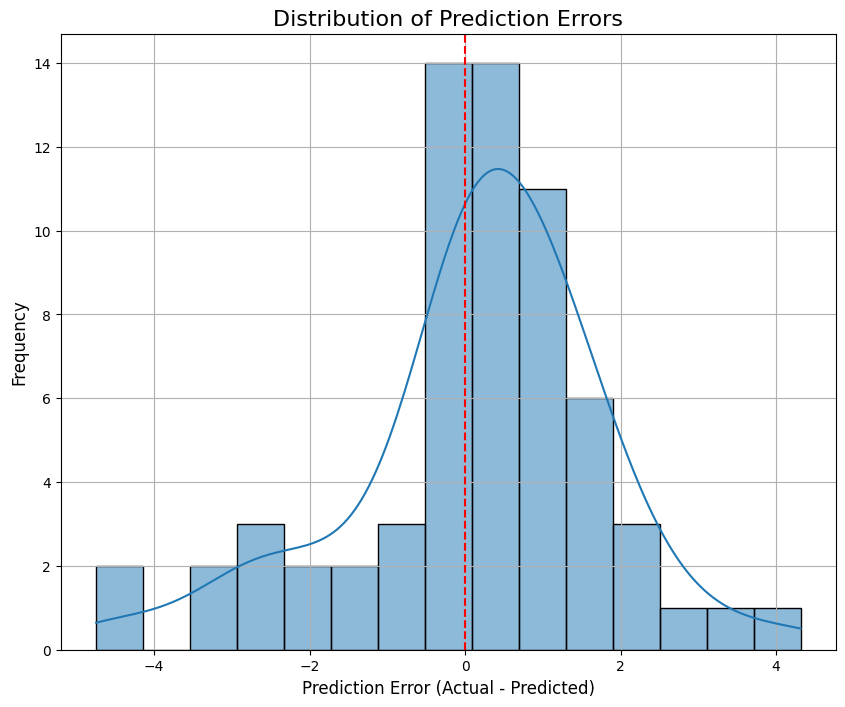


--- Top 15 Most Important Features ---


,Importance
base_score_mean,0.370035
availability_impact_numeric_mean,0.245592
integrity_impact_numeric_mean,0.198565
base_score_max,0.064704
confidentiality_impact_numeric_mean,0.057295
base_score_std,0.042108
cve_count,0.021701


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Prediction vs. Actual Scatter Plot ---

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Add a line for perfect predictions
perfect_line = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

plt.title('Actual vs. Predicted Risk Scores', fontsize=16)
plt.xlabel('Actual Score', fontsize=12)
plt.ylabel('Predicted Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig("actual_vs_predicted.png")
plt.show()


# --- 2. Error Distribution Histogram ---

# Calculate the errors (residuals)
errors = y_test - y_pred

plt.figure(figsize=(10, 8))
sns.histplot(errors, kde=True, bins=15) # kde=True adds a smooth curve

# Add a vertical line at zero to show the center
plt.axvline(0, color='red', linestyle='--')

plt.title('Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.savefig("error_distribution.png")
plt.show()

# --- 3. Feature Importance Table ---
# You can also present the feature importance data as a formal table

feature_importances = pd.Series(xgbr.feature_importances_, index=X.columns).sort_values(ascending=False)
importance_df = pd.DataFrame(feature_importances, columns=['Importance']).head(15)

print("\n--- Top 15 Most Important Features ---")
display(importance_df)

In [7]:
import pandas as pd
import joblib
from pathlib import Path

# --- 1. LOAD ARTIFACTS ---

# Load the trained model
MODEL_PATH = Path('../models/vulnerability_ranker.joblib')
model = joblib.load(MODEL_PATH)

# Load the CWE profiles data (our "knowledge base")
PROFILES_PATH = Path('../Data/cwe_profiles.csv')
cwe_profiles = pd.read_csv(PROFILES_PATH, index_col='cwe_id')

# Load the columns the model was trained on.
# We need this to ensure the input for prediction has the exact same structure.
TRAINING_COLUMNS_PATH = Path('../models/training_columns.joblib')
training_columns = joblib.load(TRAINING_COLUMNS_PATH)

print("✅ Model and data artifacts loaded successfully.")


# --- 2. CREATE ZAP-TO-CWE MAPPING ---
# In a real project, this would be a separate JSON or CSV file.
# This dictionary maps the name of a ZAP alert to its corresponding CWE ID.
zap_to_cwe_map = {
    # You can find these mappings in the ZAP documentation or online.
    "SQL Injection": "CWE-89",
    "Cross-Site Scripting (Reflected)": "CWE-79",
    "Path Traversal": "CWE-22",
    "OS Command Injection": "CWE-78",
    "Missing Anti-CSRF Tokens": "CWE-352",
    "Insecure Deserialization": "CWE-502",
    "Server-Side Request Forgery (SSRF)": "CWE-918",
    "XML External Entity (XXE)": "CWE-611"
}
print("✅ ZAP-to-CWE mapping created.")


# --- 3. BUILD THE PREDICTION FUNCTION ---

def predict_risk(vulnerability_name: str):
    """
    Takes a vulnerability name, looks up its profile, and predicts its risk score.
    """
    # Step 1: Map vulnerability name to CWE ID
    cwe_id = zap_to_cwe_map.get(vulnerability_name)
    if not cwe_id:
        return f"Error: '{vulnerability_name}' not found in our mapping."

    # Step 2: Fetch the pre-computed profile for that CWE
    try:
        profile = cwe_profiles.loc[[cwe_id]]
    except KeyError:
        return f"Error: No profile found for {cwe_id}. The model wasn't trained on this weakness type."

    # Step 3: Prepare the profile for the model
    # It must have the exact same columns as the data the model was trained on.
    
    # Drop columns that are not features
    features_to_drop = [
        'actual_risk_score', 'av_weight', 'pr_weight', 'attack_vector_<lambda>',
        'privileges_required_<lambda>', 'user_interaction_<lambda>'
    ]
    profile_features = profile.drop(columns=features_to_drop, errors='ignore')

    # One-hot encode the categorical features
    profile_encoded = pd.get_dummies(profile_features)
    
    # Reindex to match the training data columns. This adds missing columns (with a value of 0)
    # and ensures the column order is identical. This is a critical step.
    profile_final = profile_encoded.reindex(columns=training_columns, fill_value=0)

    # Step 4: Make the prediction
    predicted_score = model.predict(profile_final)
    
    # Return the single score value, rounded to 2 decimal places
    return round(predicted_score[0], 2)


# --- 4. TEST THE FUNCTION ---

print("\n--- Testing the Model ---")

# Test with a few sample vulnerabilities
test_vulns = [
    "SQL Injection",
    "Cross-Site Scripting (Reflected)",
    "Path Traversal",
    "A vulnerability that does not exist" # Example of a failed lookup
]

for vuln in test_vulns:
    score = predict_risk(vuln)
    print(f"Prediction for '{vuln}': {score}")

✅ Model and data artifacts loaded successfully.
✅ ZAP-to-CWE mapping created.

--- Testing the Model ---
Prediction for 'SQL Injection': 15.479999542236328
Prediction for 'Cross-Site Scripting (Reflected)': 9.529999732971191
Prediction for 'Path Traversal': 13.270000457763672
Prediction for 'A vulnerability that does not exist': Error: 'A vulnerability that does not exist' not found in our mapping.


In [8]:
import csv
from collections import defaultdict

# The provided ZAP_TO_CWE_MAP
ZAP_TO_CWE_MAP = {
    'Directory Browsing': 'CWE-548',
    'Private IP Disclosure': 'CWE-497',
    'Session ID in URL Rewrite': 'CWE-598',
    'Referer Exposes Session ID': 'CWE-598',
    'Path Traversal': 'CWE-22',
    'Remote File Inclusion': 'CWE-98',
    'Source Code Disclosure - Git': 'CWE-541',
    'Source Code Disclosure - SVN': 'CWE-541',
    'Source Code Disclosure - File Inclusion': 'CWE-541',
    'Vulnerable JS Library': 'CWE-1395',
    'In Page Banner Information Leak': 'CWE-497',
    'Cookie No HttpOnly Flag': 'CWE-1004',
    'Cookie Without Secure Flag': 'CWE-614',
    'Cross-Domain JavaScript Source File Inclusion': 'CWE-829',
    'Content-Type Header Missing': 'CWE-345',
    'Content-Type Header Empty': 'CWE-345',
    'Missing Anti-clickjacking Header': 'CWE-1021',
    'Multiple X-Frame-Options Header Entries': 'CWE-1021',
    'X-Frame-Options Defined via META (Non-compliant with Spec)': 'CWE-1021',
    'X-Frame-Options Setting Malformed': 'CWE-1021',
    'X-Content-Type-Options Header Missing': 'CWE-693',
    'Information Disclosure - Debug Error Messages': 'CWE-1295',
    'Information Disclosure - Sensitive Information in URL': 'CWE-598',
    'Information Disclosure - Sensitive Information in HTTP Referrer Header': 'CWE-598',
    'HTTP Parameter Override': 'CWE-20',
    'Information Disclosure - Suspicious Comments': 'CWE-615',
    'Off-site Redirect': 'CWE-601',
    'Cookie Poisoning': 'CWE-565',
    'User Controllable Charset': 'CWE-20',
    'User Controllable HTML Element Attribute (Potential XSS)': 'CWE-20',
    'Potential IP Addresses Found in the Viewstate': 'CWE-642',
    'Emails Found in the Viewstaterelease': 'CWE-642',
    'Old Asp.Net Version in Userelease': 'CWE-642',
    'Viewstate without MAC Signature (Unsure)': 'CWE-642',
    'Viewstate without MAC Signature (Sure)': 'CWE-642',
    'Split Viewstate in Userelease': 'CWE-642',
    'Heartbleed OpenSSL Vulnerability (Indicative)': 'CWE-119',
    'Strict-Transport-Security Header Not Set': 'CWE-319',
    'Strict-Transport-Security Disabled': 'CWE-319',
    'Strict-Transport-Security Multiple Header Entries (Non-compliant with Spec)': 'CWE-319',
    'Strict-Transport-Security Header on Plain HTTP Responserelease': 'CWE-319',
    'Strict-Transport-Security Missing Max-Age (Non-compliant with Spec)': 'CWE-319',
    'Strict-Transport-Security Defined via META (Non-compliant with Spec)': 'CWE-319',
    'Strict-Transport-Security Max-Age Malformed (Non-compliant with Spec)': 'CWE-319',
    'Strict-Transport-Security Malformed Content (Non-compliant with Spec)': 'CWE-319',
    'Server Leaks its Webserver Application via "Server" HTTP Response Header Field': 'CWE-497',
    'Server Leaks Version Information via "Server" HTTP Response Header Field': 'CWE-497',
    'Server Leaks Information via "X-Powered-By" HTTP Response Header Field(s)': 'CWE-497',
    'Content Security Policy (CSP) Header Not Set': 'CWE-693',
    'Obsolete Content Security Policy (CSP) Header Found': 'CWE-693',
    'Content Security Policy (CSP) Report-Only Header Found': 'CWE-693',
    'X-Backend-Server Header Information Leak': 'CWE-497',
    'Secure Pages Include Mixed Content': 'CWE-311',
    'HTTP to HTTPS Insecure Transition in Form Post': 'CWE-319',
    'HTTPS to HTTP Insecure Transition in Form Post': 'CWE-319',
    'User Controllable JavaScript Event (XSS)': 'CWE-20',
    'Big Redirect Detected (Potential Sensitive Information Leak)': 'CWE-201',
    'Multiple HREFs Redirect Detected (Potential Sensitive Information Leak)': 'CWE-201',
    'Source Code Disclosure - /WEB-INF Folder': 'CWE-541',
    'Properties File Disclosure - /WEB-INF folder': 'CWE-541',
    'HTTPS Content Available via HTTP': 'CWE-311',
    'Remote Code Execution - Shell Shock': 'CWE-78',
    'Non-Storable Content': 'CWE-524',
    'Storable but Non-Cacheable Content': 'CWE-524',
    'Storable and Cacheable Content': 'CWE-524',
    'Relative Path Confusion': 'CWE-20',
    'X-ChromeLogger-Data (XCOLD) Header Information Leak': 'CWE-532',
    'Cookie without SameSite Attribute': 'CWE-1275',
    'Cookie with SameSite Attribute None': 'CWE-1275',
    'Cookie with Invalid SameSite Attribute': 'CWE-1275',
    'CSP: X-Content-Security-Policy': 'CWE-693',
    'CSP: X-WebKit-CSP': 'CWE-693',
    'CSP: Notices': 'CWE-693',
    'CSP: Wildcard Directive': 'CWE-693',
    'CSP: script-src unsafe-inline': 'CWE-693',
    'CSP: style-src unsafe-inline': 'CWE-693',
    'CSP: script-src unsafe-hashes': 'CWE-693',
    'CSP: style-src unsafe-hashes': 'CWE-693',
    'CSP: Malformed Policy (Non-ASCII)': 'CWE-693',
    'CSP: script-src unsafe-eval': 'CWE-693',
    'CSP: Meta Policy Invalid Directive': 'CWE-693',
    'CSP: Header & Meta': 'CWE-693',
    'CSP: Failure to Define Directive with No Fallback': 'CWE-693',
    'X-Debug-Token Information Leak': 'CWE-489',
    'Username Hash Found': 'CWE-284',
    'GET for POST': 'CWE-16',
    'X-AspNet-Version Response Header': 'CWE-933',
    'PII Disclosure': 'CWE-359',
    'Permissions Policy Header Not Set': 'CWE-693',
    'Deprecated Feature Policy Header Set': 'CWE-16',
    'ASP.NET ViewState Disclosure': 'CWE-319',
    'ASP.NET ViewState Integrity': 'CWE-642',
    'Base64 Disclosure': 'CWE-319',
    'Backup File Disclosure': 'CWE-530',
    'Timestamp Disclosure - Unix': 'CWE-497',
    'Hash Disclosure - MD4 / MD5': 'CWE-497',
    'Cross-Domain Misconfiguration': 'CWE-264',
    'Source Code Disclosure - PHP': 'CWE-540',
    'Access Control Issue - Improper Authentication': 'CWE-287',
    'Access Control Issue - Improper Authorization': 'CWE-205',
    'Image Exposes Location or Privacy Data': 'CWE-200',
    'Authentication Credentials Captured': 'CWE-287',
    'Weak Authentication Method': 'CWE-326',
    'HTTP Only Site': 'CWE-311',
    'Httpoxy - Proxy Header Misuse': 'CWE-20',
    'Reverse Tabnabbing': 'CWE-1022',
    'Dangerous JS Functions': 'CWE-749',
    'Script Served From Malicious Domain (polyfill)': 'CWE-829',
    'Absence of Anti-CSRF Tokens': 'CWE-352',
    'Anti-CSRF Tokens Check': 'CWE-352',
    'HTTP Parameter Pollution': 'CWE-20',
    'Heartbleed OpenSSL Vulnerability': 'CWE-119',
    'Source Code Disclosure - CVE-2012-1823': 'CWE-20',
    'Remote Code Execution - CVE-2012-1823': 'CWE-20',
    'External Redirect': 'CWE-601',
    'Buffer Overflow': 'CWE-120',
    'Format String Error': 'CWE-134',
    'Integer Overflow Error': 'CWE-190',
    'CRLF Injection': 'CWE-113',
    'Parameter Tampering': 'CWE-472',
    'Server Side Include': 'CWE-97',
    'Cross Site Scripting (Reflected)': 'CWE-79',
    'Session Fixation': 'CWE-384',
    'Cross Site Scripting (Persistent)': 'CWE-79',
    'LDAP Injection': 'CWE-90',
    'SQL Injection': 'CWE-89',
    'SQL Injection - MySQL (Time Based)': 'CWE-89',
    'SQL Injection - Hypersonic SQL (Time Based)': 'CWE-89',
    'SQL Injection - Oracle (Time Based)': 'CWE-89',
    'SQL Injection - PostgreSQL (Time Based)': 'CWE-89',
    'Possible Username Enumeration': 'CWE-204',
    'SQL Injection - SQLite (Time Based)': 'CWE-89',
    'Proxy Disclosure': 'CWE-204',
    'Cross Site Scripting (DOM Based)': 'CWE-79',
    'SQL Injection - MsSQL (Time Based)': 'CWE-89',
    'ELMAH Information Leak': 'CWE-941',
    'Trace.axd Information Leak': 'CWE-215',
    'Out of Band XSS': 'CWE-79',
    '.htaccess Information Leak': 'CWE-941',
    'NoSQL Injection - MongoDB': 'CWE-943',
    '.env Information Leak': 'CWE-215',
    'Hidden File Found': 'CWE-538',
    'JWT Scan Rule': 'CWE-348',
    'Web Cache Deception': 'CWE-451',
    'CORS Misconfiguration': 'CWE-942',
    'File Upload': 'CWE-434',
    'Spring Actuator Information Leak': 'CWE-215',
    'Log4Shell (CVE-2021-44228)': 'CWE-117',
    'Log4Shell (CVE-2021-45046)': 'CWE-117',
    'Exponential Entity Expansion (Billion Laughs Attack)': 'CWE-776',
    'Spring4Shell': 'CWE-78',
    'Server Side Request Forgery': 'CWE-918',
    'Text4shell (CVE-2022-42889)': 'CWE-117',
    'GraphQL Endpoint Supports Introspection': 'CWE-16',
    'GraphQL Server Implementation Identified': 'CWE-205',
    'Insecure JSF ViewState': 'CWE-642',
    'Java Serialization Object': 'CWE-502',
    'Sub Resource Integrity Attribute Missing': 'CWE-345',
    'Insufficient Site Isolation Against Spectre Vulnerability': 'CWE-693',
    'Sec-Fetch-Site Header is Missing': 'CWE-352',
    'Sec-Fetch-Mode Header is Missing': 'CWE-352',
    'Sec-Fetch-Dest Header is Missing': 'CWE-352',
    'Sec-Fetch-User Header is Missing': 'CWE-352',
    'Sec-Fetch-Site Header Has an Invalid Value': 'CWE-352',
    'Sec-Fetch-Mode Header Has an Invalid Value': 'CWE-352',
    'Sec-Fetch-Dest Header Has an Invalid Value': 'CWE-352',
    'Sec-Fetch-User Header Has an Invalid Value': 'CWE-352',
    'Charset Mismatch': 'CWE-436',
    'XSLT Injection': 'CWE-91',
    'Advanced SQL Injection': 'CWE-89',
    'Server Side Code Injection - PHP Code Injection': 'CWE-94',
    'Server Side Code Injection - ASP Code Injection': 'CWE-94',
    'Remote OS Command Injection': 'CWE-78',
    'XPath Injection': 'CWE-643',
    'XML External Entity Attack': 'CWE-611',
    'Generic Padding Oracle': 'CWE-209',
    'Expression Language Injection': 'CWE-917',
    'SOAP Action Spoofing': 'CWE-451',
    'Cookie Slack Detector': 'CWE-205',
    'Insecure HTTP Method': 'CWE-749',
    'SOAP XML Injection': 'CWE-91',
    'Loosely Scoped Cookie': 'CWE-565',
    'Cloud Metadata Potentially Exposed': 'CWE-1230',
    'Server Side Template Injection': 'CWE-1336',
    'Server Side Template Injection (Blind)': 'CWE-1336',
    'Remote OS Command Injection (Time Based)': 'CWE-78',
    'NoSQL Injection - MongoDB (Time Based)': 'CWE-943',
}

def check_cwe_presence(csv_path, zap_cwe_map):
    # Extract unique CWEs from the ZAP_TO_CWE_MAP
    zap_cwes = set(zap_cwe_map.values())
    
    # Read the CSV file and collect CWE IDs
    csv_cwes = set()
    with open(csv_path, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            cwe_id = row.get('cwe_id')
            if cwe_id and cwe_id != 'N/A':
                csv_cwes.add(cwe_id)
    
    # Find missing CWEs
    missing_cwes = zap_cwes - csv_cwes
    
    # Group missing CWEs by their base number for better reporting
    missing_by_base = defaultdict(list)
    for cwe in sorted(missing_cwes):
        try:
            base_num = int(cwe.split('-')[1])
            missing_by_base[base_num].append(cwe)
        except (IndexError, ValueError):
            missing_by_base['invalid_format'].append(cwe)
    
    return {
        'total_zap_cwes': len(zap_cwes),
        'total_csv_cwes': len(csv_cwes),
        'missing_count': len(missing_cwes),
        'missing_cwes': missing_cwes,
        'missing_by_base': dict(missing_by_base)
    }

if __name__ == "__main__":
    csv_path = r'd:\VulnScanAI\Data\cwe_profiles.csv'
    results = check_cwe_presence(csv_path, ZAP_TO_CWE_MAP)
    
    print(f"Total unique CWEs in ZAP_TO_CWE_MAP: {results['total_zap_cwes']}")
    print(f"Total CWEs in CSV: {results['total_csv_cwes']}")
    print(f"\nMissing {results['missing_count']} CWEs in the profiles:")
    
    if results['missing_count'] > 0:
        print("\nMissing CWEs by base number:")
        for base, cwes in sorted(results['missing_by_base'].items()):
            if base == 'invalid_format':
                print(f"  Invalid CWE formats: {', '.join(cwes)}")
            else:
                print(f"  CWE-{base} ({len(cwes)} variants): {', '.join(cwes)}")
        
        print("\nAll missing CWEs (alphabetical order):")
        for cwe in sorted(results['missing_cwes']):
            print(f"  - {cwe}")
    else:
        print("All CWEs from ZAP_TO_CWE_MAP are present in the profiles!")

Total unique CWEs in ZAP_TO_CWE_MAP: 74
Total CWEs in CSV: 321

Missing 0 CWEs in the profiles:
All CWEs from ZAP_TO_CWE_MAP are present in the profiles!


--- 1. Descriptive Statistics of the Dataset ---
       base_score_mean  base_score_max  base_score_std  \
count       322.000000      322.000000      322.000000   
mean          6.731752        8.275466        1.029799   
std           1.338927        1.883091        0.770058   
min           0.000000        0.000000        0.000000   
25%           5.991975        6.800000        0.000000   
50%           6.814286        9.100000        1.183986   
75%           7.500000        9.800000        1.554545   
max          10.000000       10.000000        3.850866   

       confidentiality_impact_numeric_mean  integrity_impact_numeric_mean  \
count                           322.000000                     322.000000   
mean                              1.674620                       1.363973   
std                               1.043383                       1.067209   
min                               0.000000                       0.000000   
25%                               1.000000 

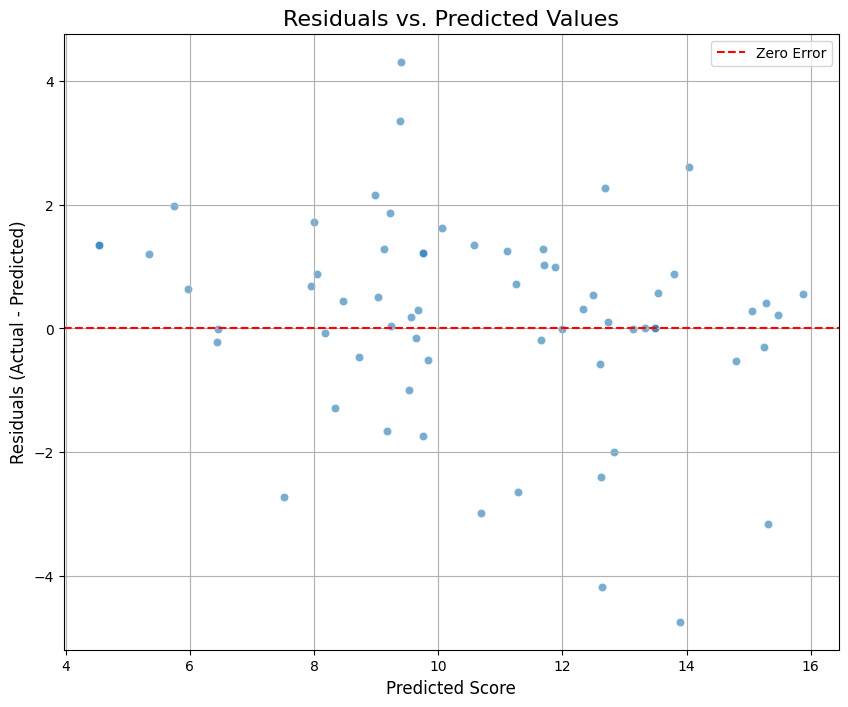

Plot saved as residuals_vs_predicted_plot.png



--- 4. Top 10 Predictions with Largest Errors ---
         Actual_Score  Predicted_Score  Absolute Error
cwe_id                                                
CWE-280      9.150000        13.895224        4.745224
CWE-119     13.718333         9.401951        4.316382
CWE-126      8.460000        12.646334        4.186334
CWE-20      12.746154         9.393170        3.352983
CWE-453     12.150000        15.318524        3.168524
CWE-472      7.710000        10.690826        2.980826
CWE-791      4.800000         7.521401        2.721401
CWE-259      8.640000        11.283053        2.643053
CWE-114     16.650000        14.043262        2.606738
CWE-805     10.224000        12.627741        2.403741




In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Load Data, Model and Recreate Predictions ---

# Define file paths (ensure these files are in your directory)
DATA_PATH = r'D:\VulnScanAI\Data\cwe_profiles.csv'
MODEL_PATH = r'D:\VulnScanAI\models\vulnerability_ranker.joblib'
COLUMNS_PATH = r'D:\VulnScanAI\models\training_columns.joblib'

# Load the dataset
try:
    cwe_profiles = pd.read_csv(DATA_PATH, index_col='cwe_id')
    model = joblib.load(MODEL_PATH)
    training_columns = joblib.load(COLUMNS_PATH)
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure cwe_profiles.csv, vulnerability_ranker.joblib, and training_columns.joblib are in the correct directory.")
    exit()

# Define target and features
y = cwe_profiles['actual_risk_score']
features_to_drop = [
    'actual_risk_score', 'av_weight', 'pr_weight', 'attack_vector_<lambda>',
    'privileges_required_<lambda>', 'user_interaction_<lambda>'
]
X = cwe_profiles.drop(columns=features_to_drop, errors='ignore')
X = pd.get_dummies(X)

# Recreate the exact same train/test split to get the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions on the test set
y_pred = model.predict(X_test)


# --- 2. Generate Descriptive Statistics Table ---
print("--- 1. Descriptive Statistics of the Dataset ---")
descriptive_stats = cwe_profiles.describe()
print(descriptive_stats)
print("\n" + "="*50 + "\n")


# --- 3. Generate Comprehensive Model Performance Metrics Table ---
print("--- 2. Comprehensive Model Performance Metrics ---")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

metrics_data = {
    'Metric': ['Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R-squared (R²)', 'Mean Squared Error (MSE)'],
    'Value': [rmse, mae, r2, mse]
}
metrics_df = pd.DataFrame(metrics_data).set_index('Metric')
print(metrics_df)
print("\n" + "="*50 + "\n")


# --- 4. Generate Residuals vs. Predicted Values Plot ---
print("--- 3. Generating Residuals vs. Predicted Values Plot ---")
errors = y_test - y_pred

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=errors, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')

plt.title('Residuals vs. Predicted Values', fontsize=16)
plt.xlabel('Predicted Score', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig("residuals_vs_predicted_plot.png")
plt.show()
print("Plot saved as residuals_vs_predicted_plot.png\n")
print("\n" + "="*50 + "\n")


# --- 5. Generate Table of Predictions with Largest Errors ---
print("--- 4. Top 10 Predictions with Largest Errors ---")
predictions_df = pd.DataFrame({'Actual_Score': y_test, 'Predicted_Score': y_pred})
predictions_df['Absolute Error'] = (predictions_df['Actual_Score'] - predictions_df['Predicted_Score']).abs()

# Sort by the absolute error in descending order and show the top 10
largest_errors_df = predictions_df.sort_values(by='Absolute Error', ascending=False).head(10)
print(largest_errors_df)
print("\n" + "="*50 + "\n")